# **RQ1: Do referees allocate stoppage time in a way that favours teams with or without superstar players?**

## Load data

Use match data from the top 5 European leagues (England, Spain, Germany, Italy, France) from the 2017/2018 season.

In [36]:
import pandas as pd

# Load the events data from the JSON file
leagues = ['Germany', 'England', 'France', 'Italy', 'Spain']
league_ids = {}

events_df = pd.read_json(f'data/events/events_{leagues[0]}.json')
matches_df = pd.read_json(f'data/matches/matches_{leagues[0]}.json')
league_ids[matches_df.loc[0, 'competitionId']] = leagues[0]
print("Finished importing", leagues[0])

# Combine events from all leagues into one dataframe, matches_df
for league in leagues[1:]:
    events_df_temp = pd.read_json(f'data/events/events_{league}.json')
    matches_df_temp = pd.read_json(f'data/matches/matches_{league}.json')
    events_df = pd.concat([events_df, events_df_temp])
    matches_df = pd.concat([matches_df, matches_df_temp])
    league_ids[matches_df_temp.loc[0, 'competitionId']] = league
    print("Finished importing", league)

matches_df = matches_df.set_index('wyId')
events_df.reset_index(inplace=True)

# Preview the DataFrame
print(matches_df.shape)
display(events_df.head())
display(matches_df.head())


Finished importing Germany
Finished importing England
Finished importing France
Finished importing Italy
Finished importing Spain
(1826, 13)


,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,0,8,Simple pass,[{'id': 1801}],15231,"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",2516739,Pass,2446,1H,2.409746,85,179896442
1,1,8,Simple pass,[{'id': 1801}],14786,"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",2516739,Pass,2446,1H,2.506082,85,179896443
2,2,8,Simple pass,[{'id': 1801}],14803,"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",2516739,Pass,2446,1H,6.946706,85,179896444
3,3,8,Simple pass,[{'id': 1801}],14768,"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",2516739,Pass,2446,1H,10.786491,85,179896445
4,4,8,Simple pass,[{'id': 1801}],14803,"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",2516739,Pass,2446,1H,12.684514,85,179896446


,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,label,date,referees,duration,competitionId
wyId,,,,,,,,,,,,,
2517036,Played,4405517,34,"{'2444': {'scoreET': 0, 'coachId': 14710, 'sid...",181137,2018-05-12 13:30:00,2445,Allianz Arena,"Bayern M\u00fcnchen - Stuttgart, 1 - 4","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 379444, 'role': 'referee'}, {'r...",Regular,426
2517037,Played,4405517,34,"{'2482': {'scoreET': 0, 'coachId': 272299, 'si...",181137,2018-05-12 13:30:00,2482,WIRSOL Rhein-Neckar-Arena,"Hoffenheim - Borussia Dortmund, 3 - 1","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 384936, 'role': 'referee'}, {'r...",Regular,426
2517038,Played,4405517,34,"{'2457': {'scoreET': 0, 'coachId': 18987, 'sid...",181137,2018-05-12 13:30:00,2975,Olympiastadion Berlin,"Hertha BSC - RB Leipzig, 2 - 6","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 387276, 'role': 'referee'}, {'r...",Regular,426
2517039,Played,4405517,34,"{'2453': {'scoreET': 0, 'coachId': 14977, 'sid...",181137,2018-05-12 13:30:00,2453,Schwarzwald-Stadion,"Freiburg - Augsburg, 2 - 0","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 378957, 'role': 'referee'}, {'r...",Regular,426
2517040,Played,4405517,34,"{'2449': {'scoreET': 0, 'coachId': 447924, 'si...",181137,2018-05-12 13:30:00,2449,VELTINS-Arena,"Schalke 04 - Eintracht Frankfurt, 1 - 0","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 387273, 'role': 'referee'}, {'r...",Regular,426


## Figure out the score at the 90 minute mark of the match, before entering stoppage time
This is necessary to determine if the referee's decision of the amount of stoppage time to add benefits one team over the other.

In [37]:
# Helper function to return a tuple of the IDs of the two teams involved in a match, given the match id
def get_teams(matchId):
    return tuple(map(int, matches_df.loc[matchId]['teamsData'].keys()))

get_teams(2517036)

(2444, 2445)

In [38]:
# create new empty column called 'goal', to indicate if a given event is a goal, and if so, the ID of the team that scored it
events_df['goal'] = 0
length = events_df.shape[0]

# iterate through each event, and update the 'goal' column if the event is a goal
for i, row in events_df.iterrows():
    tags = row['tags']
    eventName = row['eventName']
    teamId = row['teamId']
    matchId = row['matchId']
    if isinstance(tags, list):  # not sure why tags are sometimes NaN
        for tag_dict in tags:
            if tag_dict['id'] == 101 and eventName != 'Save attempt':  # 101 is the tag for a goal
                events_df.at[i, 'goal'] = teamId
            if tag_dict['id'] == 102 and eventName != 'Save attempt':  # 102 is the tag for an own goal, which is credited to the other team
                teams = get_teams(matchId)
                events_df.at[i, 'goal'] = teams[0] if teamId == teams[1] else teams[1]  # if the own goal was scored by team 1, credit it to team 2, and vice versa
    if i % 100000 == 0:  # print progress every 100,000 events
        print(f"\rChecked {i} / {length} events...", end="")
        
print("\rFinished updating 'goal' column")

Finished updating 'goal' columns...


In [39]:
# Count the score at the 90 minute mark
ninety_min_df = events_df[(events_df['matchPeriod'] == '1H') | (events_df['eventSec'] <= 2700)]
goal_counts = ninety_min_df.groupby('matchId')['goal'].value_counts()
del ninety_min_df

print(goal_counts.head(10))

matchId  goal
2499719  0       1683
         1609       4
         1631       3
2499720  0       1533
         1625       2
2499721  0       1485
         1646       3
         1610       2
2499722  0       1463
         1673       3
Name: count, dtype: int64


## Figure out how many minutes of stoppage time were added
We do this by finding the timestamp of the last event in the 2nd half of the match.

In [40]:
# Get the timestamp of the last event in the 2nd half of each match
second_half_df = events_df[events_df['matchPeriod'] == '2H']
match_stats_df = second_half_df.groupby('matchId').agg({'eventSec': 'max'})
del second_half_df

print(match_stats_df.head(10))
match_stats_df.shape

            eventSec
matchId             
2499719  3006.647279
2499720  2881.511704
2499721  2965.003397
2499722  2879.435633
2499723  2946.886247
2499724  2883.667683
2499725  2893.212822
2499726  2879.177502
2499727  3197.824194
2499728  3018.628940


(1826, 1)

## Create a new dataframe with one row for each match, containing the following information:
- team IDs
- score at the 90 minute mark
- the amount of stoppage time added

In [41]:
match_stats_df['team1'] = ''
match_stats_df['team2'] = ''
match_stats_df['team1GoalsAt90'] = ''
match_stats_df['team2GoalsAt90'] = ''
match_stats_df['stoppageTime'] = ''
match_stats_df['league'] = ''

for matchId in match_stats_df.index:
    # Fill in teams, goals, and stoppage time after 90 mins
    match_stats_df.at[matchId, 'team1'], match_stats_df.at[matchId, 'team2'] = get_teams(matchId)
    match_stats_df.at[matchId, 'team1GoalsAt90'] = goal_counts[matchId][match_stats_df.at[matchId, 'team1']] if match_stats_df.at[matchId, 'team1'] in goal_counts[matchId] else 0
    match_stats_df.at[matchId, 'team2GoalsAt90'] = goal_counts[matchId][match_stats_df.at[matchId, 'team2']] if match_stats_df.at[matchId, 'team2'] in goal_counts[matchId] else 0
    match_stats_df.at[matchId, 'stoppageTime'] = match_stats_df.at[matchId, 'eventSec'] - 2700
    match_stats_df.at[matchId, 'league'] = matches_df.loc[matchId]['competitionId']

match_stats_df = match_stats_df.drop('eventSec', axis=1)

In [42]:
# Filter to only include close matches (score difference of 1)
close_match_stats_df = match_stats_df[abs(match_stats_df['team1GoalsAt90'] - match_stats_df['team2GoalsAt90']) == 1].copy()
close_match_stats_df.loc[:, 'winningTeam'] = close_match_stats_df.apply(lambda row: row['team1'] if row['team1GoalsAt90'] > row['team2GoalsAt90'] else row['team2'], axis=1)
close_match_stats_df = close_match_stats_df.drop(['team1GoalsAt90', 'team2GoalsAt90'], axis=1)

In [43]:
# Compute the average stoppage time and standard deviation of stoppage time for each league, so we have something to compare to
avg_stoppage_time_by_league = match_stats_df.groupby('league')['stoppageTime'].mean()
std_stoppage_time_by_league = match_stats_df.groupby('league')['stoppageTime'].std()

close_match_stats_df['avgStoppageTime'] = close_match_stats_df['league'].map(avg_stoppage_time_by_league)
close_match_stats_df['stdStoppageTime'] = close_match_stats_df['league'].map(std_stoppage_time_by_league)
close_match_stats_df['stdDeviations'] = (close_match_stats_df['stoppageTime'] - close_match_stats_df['avgStoppageTime']) / close_match_stats_df['stdStoppageTime']

close_match_stats_df.head(10)

,team1,team2,stoppageTime,league,winningTeam,avgStoppageTime,stdStoppageTime,stdDeviations
matchId,,,,,,,,
2499719,1609,1631,306.647279,364,1609,252.244736,84.144545,0.646537
2499721,1646,1610,265.003397,364,1646,252.244736,84.144545,0.151628
2499723,1623,1639,246.886247,364,1623,252.244736,84.144545,-0.063682
2499727,1644,1612,497.824194,364,1612,252.244736,84.144545,2.918543
2499728,1659,1627,318.62894,364,1627,252.244736,84.144545,0.788931
2499730,1646,1627,250.505829,364,1627,252.244736,84.144545,-0.020666
2499731,1613,1673,278.395676,364,1673,252.244736,84.144545,0.310786
2499733,1628,1612,260.057078,364,1612,252.244736,84.144545,0.092844
2499735,1609,1639,328.230658,364,1639,252.244736,84.144545,0.90304


## Compute a favourability index for each team in each match, denoting how much the decided amount of stoppage time benefits the team
The favourability index (FI) is computed as follows:
- If a team is winning at the 90 minute mark:
  - FI is (avg stoppage time added in this league – stoppage time added in this match) / (std dev of stoppage time added in this league)
  - because less than average stoppage time benefits the winning team
- If a team is losing at the 90 minute mark:
  - FI is (stoppage time added in this match – avg stoppage time added in this league) / (std dev of stoppage time added in this league)
  - because more than average stoppage time benefits the losing team

In [44]:
# Compute favourability index for each team in close matches
close_match_stats_df['team1FavIndex'] = close_match_stats_df.apply(lambda row: row['stdDeviations'] if row['team1'] != row['winningTeam'] else (-1 * row['stdDeviations']), axis=1)
close_match_stats_df['team2FavIndex'] = -1 * close_match_stats_df['team1FavIndex']
close_match_stats_df.head(10)

,team1,team2,stoppageTime,league,winningTeam,avgStoppageTime,stdStoppageTime,stdDeviations,team1FavIndex,team2FavIndex
matchId,,,,,,,,,,
2499719,1609,1631,306.647279,364,1609,252.244736,84.144545,0.646537,-0.646537,0.646537
2499721,1646,1610,265.003397,364,1646,252.244736,84.144545,0.151628,-0.151628,0.151628
2499723,1623,1639,246.886247,364,1623,252.244736,84.144545,-0.063682,0.063682,-0.063682
2499727,1644,1612,497.824194,364,1612,252.244736,84.144545,2.918543,2.918543,-2.918543
2499728,1659,1627,318.62894,364,1627,252.244736,84.144545,0.788931,0.788931,-0.788931
2499730,1646,1627,250.505829,364,1627,252.244736,84.144545,-0.020666,-0.020666,0.020666
2499731,1613,1673,278.395676,364,1673,252.244736,84.144545,0.310786,0.310786,-0.310786
2499733,1628,1612,260.057078,364,1612,252.244736,84.144545,0.092844,0.092844,-0.092844
2499735,1609,1639,328.230658,364,1639,252.244736,84.144545,0.90304,0.903040,-0.903040


In [45]:
# Create a DataFrame with just the favourability indexes
team1_fav_index_df = close_match_stats_df.loc[:, ['team1', 'team1FavIndex', 'league']]
team1_fav_index_df.columns = ['team', 'favIndex', 'league']

team2_fav_index_df = close_match_stats_df.loc[:, ['team2', 'team2FavIndex', 'league']]
team2_fav_index_df.columns = ['team', 'favIndex', 'league']

stacked_df = pd.concat([team1_fav_index_df, team2_fav_index_df])
stacked_df = stacked_df.sort_index()

stacked_df.head(10)

,team,favIndex,league
matchId,,,
2499719,1609,-0.646537,364
2499719,1631,0.646537,364
2499721,1610,0.151628,364
2499721,1646,-0.151628,364
2499723,1623,0.063682,364
2499723,1639,-0.063682,364
2499727,1644,2.918543,364
2499727,1612,-2.918543,364
2499728,1659,0.788931,364


## Find the teams with superstar players

In [46]:
# Load player and team data
player_df = pd.read_json("data/players.json")
team_df = pd.read_json("data/teams.json")

display(player_df.head())
display(team_df.head())

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,null


,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [47]:
# List of superstar player names
superstar_names = [
    "C. Immobile",
    "R. Lewandowski",
    "Neymar",
    "Cristiano Ronaldo",
    "K. De Bruyne",
    "H. Kane",
    "L. Messi",
    "P. Pogba",
    "G. Bale",
    "K. Benzema",
    "Mohamed Salah",
    "A. Griezmann",
    "R. Varane",
    "E. Hazard",
    "Sergio Ramos",
    "T. Kroos",
    "P. Dybala",
]
superstar_ids = [353833, 8325, 8287, 7972, 25747, 31528]  # for manual player indexing
superstar_dict = {}  # {player_id: player_name}
teams_with_superstars = {}  # {team_id: {"clubName": club_name, "playerIds": [player_id]}}

for index, row in player_df.iterrows():
    if row['shortName'] in superstar_names or row['wyId'] in superstar_ids:
        # Perform desired operations
        short_name = row["shortName"]
        player_id = row["wyId"]
        club_id = row["currentTeamId"]
        club_name = team_df[team_df["wyId"] == club_id]["name"].values[0]

        superstar_dict[player_id] = short_name
        if club_id not in teams_with_superstars:
            teams_with_superstars[club_id] = {"clubName": club_name, "playerIds": [player_id]}
        else:
            teams_with_superstars[club_id]["playerIds"].append(player_id)

display(superstar_dict)
display(teams_with_superstars)

{3306: 'Sergio Ramos',
 3309: 'R. Varane',
 3321: 'K. Benzema',
 3322: 'Cristiano Ronaldo',
 3359: 'L. Messi',
 3682: 'A. Griezmann',
 38021: 'K. De Bruyne',
 7936: 'P. Pogba',
 7972: 'L. Su\\u00e1rez',
 40810: 'Neymar',
 8278: 'G. Bale',
 8287: 'L. Modri\\u0107',
 8325: 'S. Ag\\u00fcero',
 8717: 'H. Kane',
 14723: 'T. Kroos',
 14817: 'R. Lewandowski',
 21384: 'C. Immobile',
 120353: 'Mohamed Salah',
 25747: 'S. Man\\u00e9',
 89186: 'P. Dybala',
 353833: 'K. Mbapp\\u00e9',
 25707: 'E. Hazard',
 31528: 'N. Kant\\u00e9'}

{675: {'clubName': 'Real Madrid',
  'playerIds': [3306, 3309, 3321, 8278, 8287, 14723]},
 3159: {'clubName': 'Juventus', 'playerIds': [3322, 89186]},
 676: {'clubName': 'Barcelona', 'playerIds': [3359, 7972]},
 679: {'clubName': 'Atl\\u00e9tico Madrid', 'playerIds': [3682]},
 1625: {'clubName': 'Manchester City', 'playerIds': [38021, 8325]},
 1611: {'clubName': 'Manchester United', 'playerIds': [7936]},
 3767: {'clubName': 'PSG', 'playerIds': [40810, 353833]},
 1624: {'clubName': 'Tottenham Hotspur', 'playerIds': [8717]},
 2444: {'clubName': 'Bayern M\\u00fcnchen', 'playerIds': [14817]},
 3162: {'clubName': 'Lazio', 'playerIds': [21384]},
 1612: {'clubName': 'Liverpool', 'playerIds': [120353, 25747]},
 1610: {'clubName': 'Chelsea', 'playerIds': [25707, 31528]}}

In [48]:
# How many superstars are there?
print(len(superstar_dict))

23


In [53]:
# Add a column to the stacked_df indicating if the team has a superstar
stacked_df['has_superstar'] = stacked_df['team'].apply(lambda x: x in teams_with_superstars)
stacked_df.head(10)

,team,favIndex,league,has_superstar
matchId,,,,
2499719,1609,-0.646537,364,False
2499719,1631,0.646537,364,False
2499721,1610,0.151628,364,True
2499721,1646,-0.151628,364,False
2499723,1623,0.063682,364,False
2499723,1639,-0.063682,364,False
2499727,1644,2.918543,364,False
2499727,1612,-2.918543,364,True
2499728,1659,0.788931,364,False


## Perform a T-test to determine if the mean favourability index differs significantly between teams with and without superstar players

In [54]:
print("Mean favourability index")
means = stacked_df.groupby('has_superstar')['favIndex'].mean()
print("   Teams with superstars:", means[True])
print("   Teams without superstars:", means[False])

Mean favourability index
   Teams with superstars: -0.08151538351987005
   Teams without superstars: 0.008529933916713387


In [66]:
from scipy.stats import ttest_ind

# Get unique leagues
leagues = stacked_df['league'].unique()
p_values = {}

# Loop over leagues
for league in leagues:
    # Filter data for current league
    league_df = stacked_df[stacked_df['league'] == league]
    
    # Group by 'has_superstar'
    grouped_df = league_df.groupby('has_superstar')
    
    # Get the groups
    group1 = grouped_df.get_group(False)['favIndex']
    group2 = grouped_df.get_group(True)['favIndex']

    # Perform t-test
    t_statistic, p_value = ttest_ind(group1, group2)
    p_values[league] = p_value
    
    # Get average favourability index for each group
    avg_group1 = group1.mean()
    avg_group2 = group2.mean()

    # Print the results
    print(f"League: {league_ids[league]} (id={league})")
    print("Avg favIndex without superstar:", avg_group1)
    print("Avg favIndex with superstar:", avg_group2)
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value)
    print("")

League: England (id=364)
Avg favIndex without superstar: 0.06275271757057979
Avg favIndex with superstar: -0.2125495272551896
T-Statistic: 1.9877021805798116
P-Value: 0.04785464384505857

League: France (id=412)
Avg favIndex without superstar: -0.01731236312525063
Avg favIndex with superstar: 0.5055210032573185
T-Statistic: -1.6660784071633776
P-Value: 0.0967415467856503

League: Germany (id=426)
Avg favIndex without superstar: 0.0014134804649372863
Avg favIndex with superstar: -0.036750492088369544
T-Statistic: 0.13010226820249238
P-Value: 0.8966077256849767

League: Spain (id=795)
Avg favIndex without superstar: 0.00333723180958849
Avg favIndex with superstar: -0.031185855875809628
T-Statistic: 0.16883211356376918
P-Value: 0.8660432356917525

League: Italy (id=524)
Avg favIndex without superstar: 0.0052423848061679545
Avg favIndex with superstar: -0.06334548307452957
T-Statistic: 0.31566986836553335
P-Value: 0.7524641495957908



England is the only league where p < 0.05, meaning we can reject the null hypothesis. There is a 4.79% probability of observing a difference in favourability index between teams with and without superstar players that's at least as extreme as the one observed, assuming the null hypothesis is true.

In the English Premier League, there is statistical evidence that referees are more likely to add stoppage time in a way that benefits teams **without** superstars, given that the average favourability index for teams without superstars is significantly higher than the average favourability index for teams with superstars.

# Box and whiskers visualization

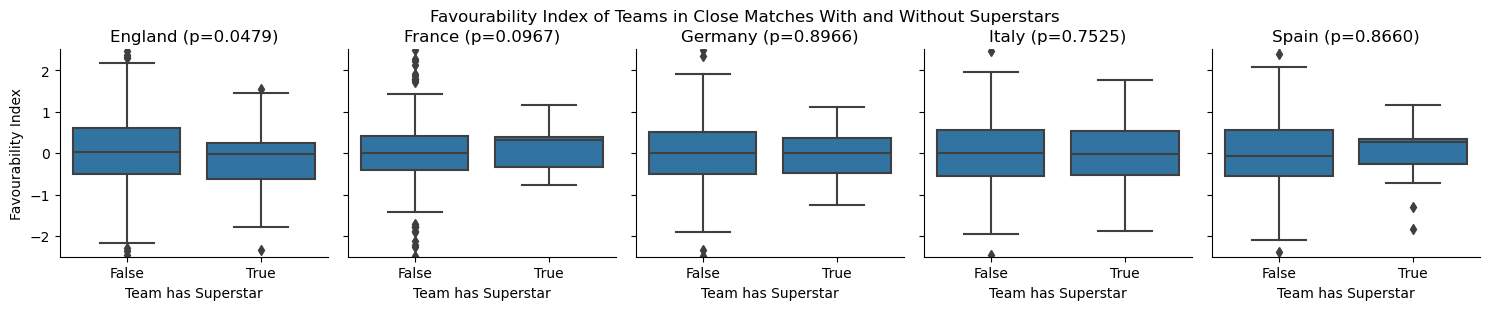

In [67]:
g = sns.FacetGrid(stacked_df, col='league')
g.map(sns.boxplot, 'has_superstar', 'favIndex', order=[False, True])

# Edit axes limits and labels
g.set(ylim=(-2.5, 2.5))
g.set_axis_labels('Team has Superstar', 'Favourability Index')

# Title
g.figure.suptitle('Favourability Index of Teams in Close Matches With and Without Superstars', y=1.02)

# Replace subplot titles with league names from dictionary
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(f"{league_ids[title]} (p={p_values[title]:.4f})")

plt.show()